# TLP


In [1]:
import functools
import math

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import tensorly as tl
from tensorly.decomposition import parafac


Using numpy backend.


In [2]:
from tlp import *


In [3]:
M = 10
N = 10
T = 20


In [4]:
k = 4


In [5]:
a = np.random.randint(20) * np.abs(np.random.randn(M, k))
b = np.random.randint(20) * np.abs(np.random.randn(N, k))
c = np.random.randint(20) * np.maximum(1 + np.sin(np.arange(T) * 2.1 * np.pi / 3.4).reshape((T, 1)) + np.random.randn(T, k), 0)


In [6]:
Z = np.zeros((M, N, T))

for i in range(k):
    Z += a[:, i].reshape((M, 1, 1)) * b[:, i].reshape((1, N, 1)) * c[:, i].reshape((1, 1, T))

Z /= Z.ravel().mean() / 4
Z = Z.round().astype(int)
Z = np.maximum(np.minimum(Z, 20), 0)
Z[~np.random.randint(2, size = Z.shape).astype(bool)] = 0


In [7]:
del a
del b
del c


In [8]:
cpd = parafac(Z.astype(float), rank = k)


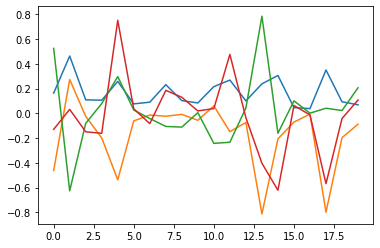

In [9]:
for i in range(k):
    plt.plot(cpd[-1][:, i])
plt.show()


In [10]:
del cpd


In [11]:
def initial_trend (series, slen):
    s = np.zeros(series.shape[1], dtype = float) if (isinstance(series, np.ndarray) and series.ndim == 2) else 0.0

    for i in range(slen):
        s += series[i + slen] - series[i]

    return s / slen ** 2

def initial_seasonal_components (series, slen):
    seasonals = list()
    season_averages = list()
    n_seasons = int(math.floor(float(len(series)) / slen))

    for j in range(n_seasons):
        season_averages.append(series[slen * j:slen * j + slen].sum(axis = 0) / slen)

    for i in range(slen):
        sum_of_vals_over_avg = np.zeros(series.shape[1], dtype = float) if (isinstance(series, np.ndarray) and series.ndim == 2) else 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen * j + i] - season_averages[j]
        seasonals.append(sum_of_vals_over_avg / n_seasons)

    return seasonals

def triple_exponential_smoothing (series, slen, alpha = 0.5, beta = 0.5, gamma = 0.5, n_preds = 1):
    result = list()
    seasonals = initial_seasonal_components(series, slen)

    smooth = series[0]
    trend = initial_trend(series, slen)

    result.append(series[0])

    for i in range(1, len(series)):
        val = series[i]
        last_smooth, smooth = (smooth, alpha * (val - seasonals[i % slen]) + (1.0 - alpha) * (smooth + trend))
        trend = beta * (smooth - last_smooth) + (1.0 - beta) * trend
        seasonals[i % slen] = gamma * (val - smooth) + (1.0 - gamma) * seasonals[i % slen]

        result.append(smooth + trend + seasonals[i % slen])

    for i in range(len(series), len(series) + n_preds):
        m = i - len(series) + 1
        result.append((smooth + m * trend) + seasonals[i % slen])

    return result[len(series):]


In [12]:
predict = functools.partial(triple_exponential_smoothing, alpha = 0.9, beta = 0.6, gamma = 0.7, slen = 3, n_preds = 1)


In [13]:
Z.shape


(10, 10, 20)

In [14]:
Zp = cp_score(Z[:, :, :-1], k = k, T0 = 11, predict = predict)


In [15]:
np.sqrt(np.square((Z[:, :, -1] - Zp).ravel()).mean())


3.056571098833093